# Load data

In [1]:
import importlib

In [2]:
from tensorflow.keras.datasets import cifar10
import pickle as pkl

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#### Download and save data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [22]:
with open("train_cifar10.pkl", "wb") as f:
    pkl.dump([x_train, y_train], f)

with open("test_cifar10.pkl", "wb") as f:
    pkl.dump([x_test, y_test], f)

#### Load downloaded data

In [4]:
with open("train_cifar10.pkl", "rb") as f:
    x_train, y_train = pkl.load(f)
    
with open("test_cifar10.pkl", "rb") as f:
    x_test, y_test = pkl.load(f)

# Pre-process data

In [6]:
try:
    importlib.reload(data)
except NameError:
    import data
    
from data import resize_img, crop_img, pca_color_augmentation, norm_preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
from PIL import Image

In [8]:
def opencv_to_pil(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    return im_pil

In [9]:
def preprocessing_function(img, augment=True):
    img_padded = cv2.copyMakeBorder(img,top=4,bottom=4,left=4,right=4,borderType=cv2.BORDER_CONSTANT,value=[0, 0, 0])
    img_cropped = crop_img(img_padded, dim_crop=(32,32))
    return img_cropped.astype(np.float32)

#### Convert labels to one-hot encoding

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
train_generator = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, preprocessing_function=preprocessing_function)
train_generator.fit(x_train)

train_batches = train_generator.flow(x_train, y_train, batch_size=128)

In [12]:
valid_generator = ImageDataGenerator(featurewise_center=True)
valid_generator.fit(x_train)

valid_batches = valid_generator.flow(x_test, y_test, batch_size=128)

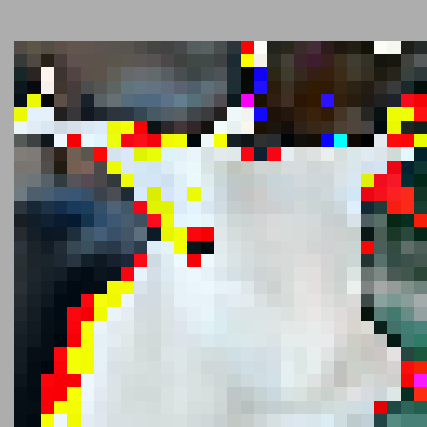

In [13]:
imgs, labels = next(train_batches)
#print(imgs[0])
opencv_to_pil(resize_img(imgs[0].astype(np.uint8)))

# Train network

In [18]:
try:
    importlib.reload(resnet)
except NameError:
    import resnet

from resnet import ResNetCIFAR

In [19]:
resnet_cifar = ResNetCIFAR()
resnet_cifar.create_model(N=5)
# resnet_cifar.model.summary()

In [20]:
resnet_cifar.train_model(train_batches, valid_batches, log_frequency=100, num_iterations = 60000)

iteration : 31, loss : 2.5643, acc : 0.1099


In [16]:
resnet_cifar.save_model('reset_cifar_60000iters.zip')